https://analyticsindiamag.com/pseudo-labelling-a-guide-to-semi-supervised-learning/

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from datetime import datetime
from contextlib import contextmanager
import time
import os
import sys
import math
import time
import pickle
import psutil
import random
from pathlib import Path


from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve,  KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

import missingno

import seaborn as sns


import sys
import warnings

import warnings
warnings.filterwarnings('ignore')

sns.set(style='white', context='notebook', palette='deep')

In [37]:
# ------------------------------------------------------------------------------
# Utilities
# ------------------------------------------------------------------------------
@contextmanager
def timer(name: str):
    t0 = time.time()
    p = psutil.Process(os.getpid())
    m0 = p.memory_info()[0] / 2. ** 30
    try:
        yield
    finally:
        m1 = p.memory_info()[0] / 2. ** 30
        delta = m1 - m0
        sign = '+' if delta >= 0 else '-'
        delta = math.fabs(delta)
        print(f"[{m1:.1f}GB({sign}{delta:.1f}GB): {time.time() - t0:.3f}sec] {name}", file=sys.stderr)


def set_seed(seed=42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)


def score_log(df: pd.DataFrame, seed: int, num_fold: int, model_name: str, cv: float):
    score_dict = {'date': datetime.now(), 'seed': seed, 'fold': num_fold, 'model': model_name, 'cv': cv}
    # noinspection PyTypeChecker
    df = pd.concat([df, pd.DataFrame.from_dict([score_dict])])
    df.to_csv(LOG_PATH / f"model_score_{model_name}.csv", index=False)
    return df

In [38]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring="roc_auc")
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()
    return plt

In [39]:
def SingleTraining(classifier, features, target,  title=None, test_size=0.2, random_state=0):
    
    with timer(title):
        X_train, X_test, y_train, y_test = train_test_split(features, target, 
                                                        test_size=test_size, 
                                                        random_state=random_state)
        classifier.fit(X_train, y_train)
        preds = classifier.predict_proba(X_test)[:, 1]
        score = roc_auc_score(y_test, preds)
        print("AUC: {0:.8f}".format(score))
        
        return score, preds
        
def cross_validation(classifier, X_train, y_train, title=None, cv=10, n_jobs=-1):
    with timer(title):
        scores = cross_val_score(classifier, X_train, y_train, cv=cv, scoring="roc_auc", n_jobs=n_jobs)
        print("AUC Mean: {0:.8f} / Std: {1:.8f}".format(scores.mean(), scores.std()))
        
        return scores

# Loading Train and Test Data

In [40]:
train = pd.read_csv("./input/train.csv", index_col='id')
test = pd.read_csv('./input/test.csv', index_col='id')

# Missing Values Investigation

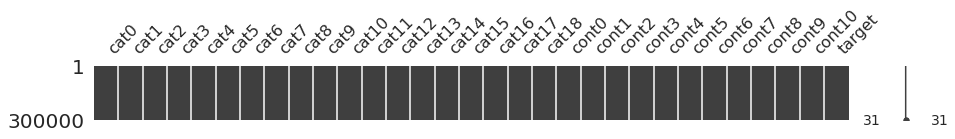

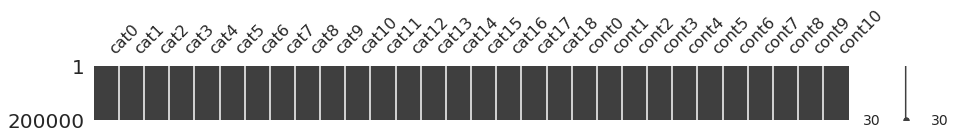

In [41]:
missingno.matrix(train, figsize=(15,1))
missingno.matrix(test,  figsize=(15,1))
plt.show()

In [42]:
print(train.isnull().sum().values)
print(test.isnull().sum().values)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [43]:
cat_cols = ['cat'+str(i) for i in range(19)]
cont_cols = ['cont'+str(i) for i in range(11)]
features = cat_cols + cont_cols

In [44]:
for cat in cat_cols:
    print(cat)
    print(train[cat].value_counts(), end='\n\n')

cat0
A    223525
B     76475
Name: cat0, dtype: int64

cat1
I    90809
F    43818
K    41870
L    31891
H    17257
N    13231
M    11354
G    11248
A    10547
J    10036
O     8740
B     6847
C     1703
D      414
E      235
Name: cat1, dtype: int64

cat2
A    168694
C     38875
D     22720
G     18225
Q     10901
F      9877
J      9102
M      8068
I      5287
L      3997
O      2749
N       340
H       219
B       218
S       197
U       166
R       129
K       126
E       110
Name: cat2, dtype: int64

cat3
A    187251
B     79951
C     15957
D      8676
E      3318
F      2489
K       846
G       372
L       292
J       286
H       274
I       177
N       111
Name: cat3, dtype: int64

cat4
E    129385
F     76678
G     30754
D     27919
H     23388
J      4307
I      3241
K      1481
M       547
C       506
O       330
B       301
S       285
T       215
L       214
Q       117
P       100
A        92
N        81
R        59
Name: cat4, dtype: int64

cat5
BI    238563
AB     41639
B

In [45]:
for cat in cat_cols:
    
    train_nunique = len(train[cat].unique())
    test_nunique  = len(test[cat].unique() )                
    diff = train_nunique - test_nunique
    print("{0:7s}".format(cat), end=" | ")  
    print("{0:5d} {1:5d} | {2:5d}".format(train_nunique, test_nunique, diff))

cat0    |     2     2 |     0
cat1    |    15    15 |     0
cat2    |    19    19 |     0
cat3    |    13    13 |     0
cat4    |    20    20 |     0
cat5    |    84    84 |     0
cat6    |    16    16 |     0
cat7    |    51    51 |     0
cat8    |    61    61 |     0
cat9    |    19    19 |     0
cat10   |   299   295 |     4
cat11   |     2     2 |     0
cat12   |     2     2 |     0
cat13   |     2     2 |     0
cat14   |     2     2 |     0
cat15   |     4     4 |     0
cat16   |     4     4 |     0
cat17   |     4     4 |     0
cat18   |     4     4 |     0


# Categorical Feature LabelEncoding

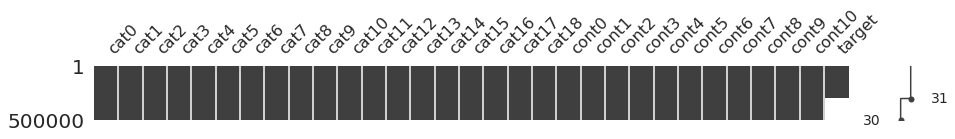

In [46]:
data = pd.concat([train, test])
missingno.matrix(data,  figsize=(15,1))
plt.show()

In [47]:
for cat in cat_cols:
    data[cat] = pd.factorize(data[cat])[0]

In [48]:
for cat in cat_cols:
    print(cat)
    print(data[cat].value_counts(), end='\n\n')

cat0
0    372548
1    127452
Name: cat0, dtype: int64

cat1
0     150961
3      72941
1      70091
4      53098
10     28804
5      21948
7      19063
11     18745
2      17803
6      16693
8      14518
9      11369
12      2867
13       724
14       375
Name: cat1, dtype: int64

cat2
0     281159
2      64558
4      37833
1      30509
6      18096
5      16415
7      15209
10     13529
9       8917
8       6699
3       4548
13       588
18       379
11       358
17       321
12       283
14       207
16       205
15       187
Name: cat2, dtype: int64

cat3
1     311757
0     133427
2      26557
3      14594
8       5448
7       4176
9       1455
4        623
12       495
11       483
6        473
10       323
5        189
Name: cat3, dtype: int64

cat4
1     215458
5     127694
6      51250
4      46801
2      39009
9       7281
3       5316
8       2468
7        956
11       854
15       570
0        484
14       454
10       345
12       344
17       174
13       168
18       142
16

In [49]:
test = data[data['target'].isnull()]
test.head()

,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,target
id,,,,,,,,,,,,,,,,,,,,,
5,0,3,0,1,5,0,0,8,6,0,...,0.578366,0.723154,0.228037,0.356227,0.551249,0.655693,0.598331,0.359987,0.947489,NaN
6,0,10,2,1,1,1,3,17,20,0,...,0.928885,0.516602,0.600169,0.795224,0.248987,0.654614,0.347944,0.565520,0.388580,NaN
8,0,5,2,1,5,1,0,8,22,0,...,0.424876,0.344729,0.242073,0.270632,0.746740,0.335590,0.341238,0.252289,0.411592,NaN
9,1,4,2,1,5,0,0,2,6,0,...,0.598943,0.561971,0.806347,0.735983,0.538724,0.381566,0.481660,0.348514,0.325723,NaN
11,0,3,0,0,5,0,0,8,26,0,...,0.479572,0.767745,0.252454,0.354810,0.178920,0.763479,0.562491,0.466261,0.585781,NaN


In [50]:
train = data[~data['target'].isnull()]
train.head()

,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,target
id,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0.759439,0.795549,0.681917,0.621672,0.592184,0.791921,0.815254,0.965006,0.665915,0.0
1,0,0,0,1,1,0,1,1,1,1,...,0.386385,0.541366,0.388982,0.357778,0.600044,0.408701,0.399353,0.927406,0.493729,0.0
2,0,1,0,1,1,0,0,2,2,2,...,0.343255,0.616352,0.793687,0.552877,0.352113,0.388835,0.412303,0.292696,0.549452,0.0
3,0,1,0,2,1,0,0,3,1,1,...,0.831147,0.807807,0.800032,0.619147,0.221789,0.897617,0.633669,0.760318,0.934242,0.0
4,0,0,1,0,1,0,2,4,0,0,...,0.338818,0.277308,0.610578,0.128291,0.578764,0.279167,0.351103,0.357084,0.328960,1.0


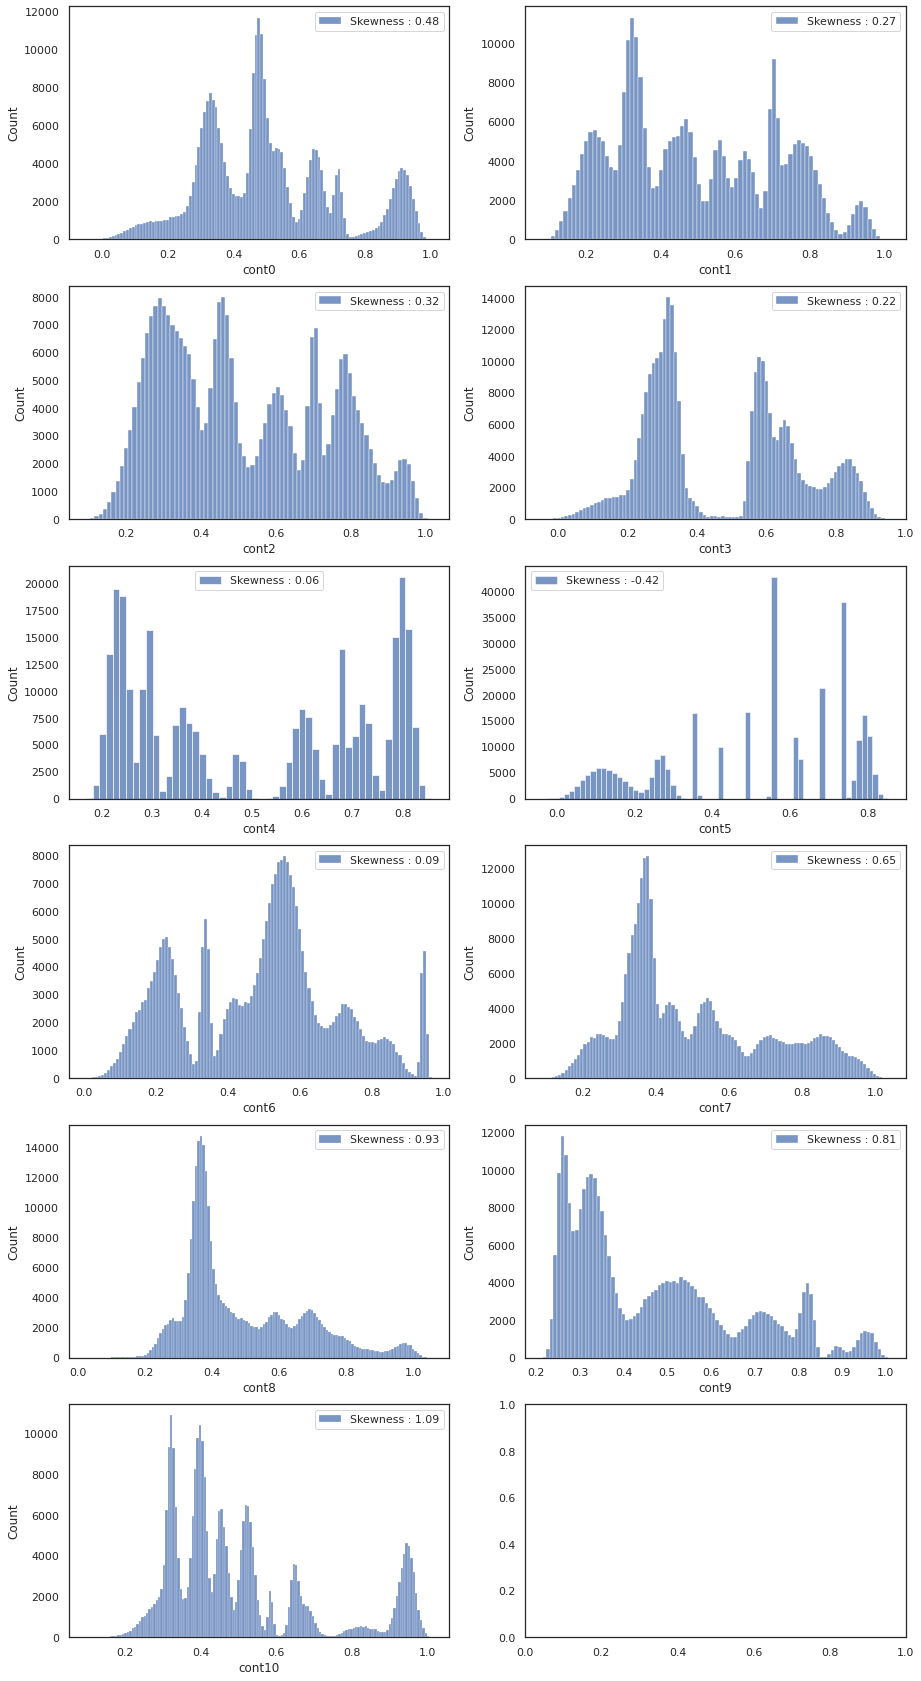

In [51]:
idx = np.arange(12, dtype=int).reshape(6,2)
fig, ax = plt.subplots(nrows=6, ncols=2, figsize=(15, 30))
for i in range(6):
    for j in range(2):
        if i!=5 or j!=1:
            feature = 'cont'+str(idx[i][j])
            sns.histplot(train[feature], ax=ax[i][j], label="Skewness : %.2f"%(train[feature].skew()))
            ax[i][j].legend()
plt.show()

In [54]:
train[cont_cols+['target']].corr()

,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,target
cont0,1.000000,0.474046,0.494622,0.549246,0.155805,-0.169393,-0.436555,0.740377,0.367794,0.414758,0.807896,-0.015172
cont1,0.474046,1.000000,0.861623,0.256854,0.133988,0.185838,0.116296,0.581201,0.672587,0.393313,0.471084,0.164655
cont2,0.494622,0.861623,1.000000,0.286822,0.158749,0.158240,0.066997,0.606447,0.662832,0.399063,0.506684,0.140459
cont3,0.549246,0.256854,0.286822,1.000000,0.222817,-0.068856,-0.429911,0.641923,0.188794,0.383062,0.611307,-0.148316
cont4,0.155805,0.133988,0.158749,0.222817,1.000000,0.037509,-0.081020,0.231526,0.064836,0.161150,0.208428,-0.075585
cont5,-0.169393,0.185838,0.158240,-0.068856,0.037509,1.000000,0.439221,-0.094008,0.141199,0.120901,-0.160551,0.215184
cont6,-0.436555,0.116296,0.066997,-0.429911,-0.081020,0.439221,1.000000,-0.361585,0.123390,-0.125960,-0.443371,0.189832
cont7,0.740377,0.581201,0.606447,0.641923,0.231526,-0.094008,-0.361585,1.000000,0.479203,0.443322,0.775453,-0.040646
cont8,0.367794,0.672587,0.662832,0.188794,0.064836,0.141199,0.123390,0.479203,1.000000,0.293181,0.382051,0.183726
cont9,0.414758,0.393313,0.399063,0.383062,0.161150,0.120901,-0.125960,0.443322,0.293181,1.000000,0.452508,0.059242


<AxesSubplot:>

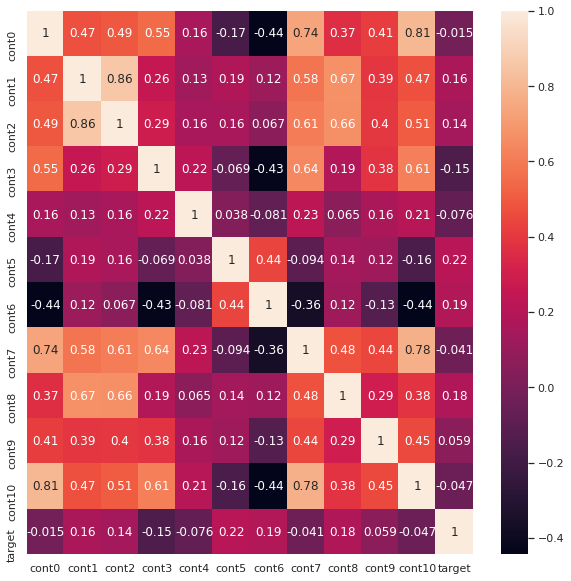

In [59]:
corr = train[cont_cols+['target']].corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr, annot=True, )

<AxesSubplot:>

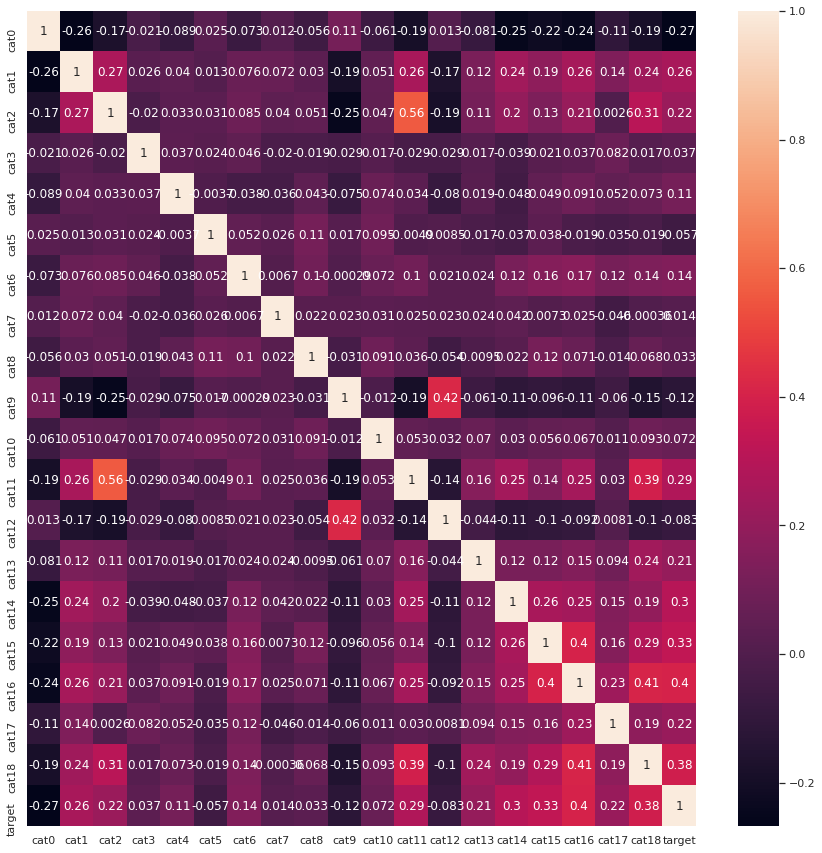

In [61]:
corr = train[cat_cols+['target']].corr()
plt.figure(figsize=(15, 15))
sns.heatmap(corr, annot=True, )

# Features and Target separation

In [62]:
train['target'] = train['target'].astype('int64')
target = train.pop('target')

In [63]:
train.head()

,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10
id,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0.855349,0.759439,0.795549,0.681917,0.621672,0.592184,0.791921,0.815254,0.965006,0.665915
1,0,0,0,1,1,0,1,1,1,1,...,0.328929,0.386385,0.541366,0.388982,0.357778,0.600044,0.408701,0.399353,0.927406,0.493729
2,0,1,0,1,1,0,0,2,2,2,...,0.322749,0.343255,0.616352,0.793687,0.552877,0.352113,0.388835,0.412303,0.292696,0.549452
3,0,1,0,2,1,0,0,3,1,1,...,0.707663,0.831147,0.807807,0.800032,0.619147,0.221789,0.897617,0.633669,0.760318,0.934242
4,0,0,1,0,1,0,2,4,0,0,...,0.274514,0.338818,0.277308,0.610578,0.128291,0.578764,0.279167,0.351103,0.357084,0.328960


In [64]:
target.head()

id
0    0
1    0
2    0
3    0
4    1
Name: target, dtype: int64

In [65]:
target.value_counts()

0    220539
1     79461
Name: target, dtype: int64

# Model : LightGBM (default)

In [22]:
lgbm_clf = LGBMClassifier()
score, preds = SingleTraining(lgbm_clf, train, target,  title='LGBM', test_size=0.2, random_state=0)

AUC: 0.88695314


[0.7GB(+0.1GB): 16.468sec] LGBM


In [23]:
X_train, y_train = train, target
lgbm_clf = LGBMClassifier()
lgbm_scores = cross_validation(lgbm_clf, X_train, y_train, title='LGBM', cv=10)

AUC Mean: 0.88892481 / Std: 0.00171935


[0.6GB(-0.1GB): 11.073sec] LGBM


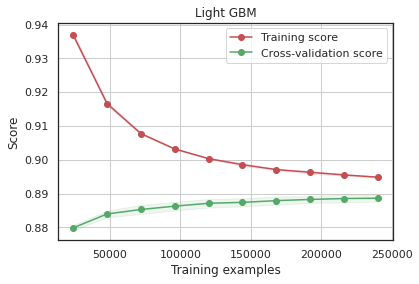

[0.6GB(+0.0GB): 28.895sec] Light GBM (default)


In [24]:
with timer("Light GBM (default)"):
    X_train, y_train = train, target
    plot_learning_curve(lgbm_clf, 'Light GBM', X_train, y_train, cv=5, n_jobs=-1, 
                        train_sizes=np.linspace(.1, 1.0, 10))

# Confusion Matrix and Related Analysis

In [145]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import precision_recall_curve, f1_score, roc_curve

In [97]:
X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=0.2, stratify=target, random_state=0)
lgbm_clf = LGBMClassifier()
lgbm_clf.fit(X_train, y_train)
results = lgbm_clf.predict_proba(X_test)
pred_proba = results[:, 1]
pred = lgbm_clf.predict(X_test)

In [128]:
pred_proba_class0 = results[:,0]
pred_proba_class1 = results[:,1]

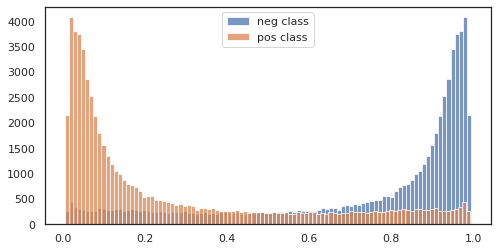

In [130]:
plt.figure(figsize=(8,4))
plt.hist(pred_proba_class0, bins=100, alpha=0.75, label='neg class')
plt.hist(pred_proba_class1, bins=100, alpha=0.75, label='pos class')
plt.legend()
plt.show()

In [118]:
pred_df = pd.DataFrame(results, columns=["class_0", "class_1"]) 

In [119]:
pred_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   class_0  60000 non-null  float64
 1   class_1  60000 non-null  float64
dtypes: float64(2)
memory usage: 937.6 KB


In [120]:
pred_df["y_test"]     = y_test.values
pred_df["prediction"] = pred

In [134]:
pred_df.head()s

,class_0,class_1,y_test,prediction
0,0.889344,0.110656,0,0
1,0.951824,0.048176,0,0
2,0.484903,0.515097,0,1
3,0.141256,0.858744,1,1
4,0.855965,0.144035,0,0


In [132]:
pred_df[pred_df["y_test"]==1].head()

,class_0,class_1,y_test,prediction
3,0.141256,0.858744,1,1
6,0.011729,0.988271,1,1
7,0.014458,0.985542,1,1
9,0.794365,0.205635,1,0
16,0.883209,0.116791,1,0


In [131]:
pred_df[pred_df["y_test"]==0].head()

,class_0,class_1,y_test,prediction
0,0.889344,0.110656,0,0
1,0.951824,0.048176,0,0
2,0.484903,0.515097,0,1
4,0.855965,0.144035,0,0
5,0.931587,0.068413,0,0


In [106]:
confusion = confusion_matrix(y_test, pred)
accuracy  = accuracy_score(y_test, pred)
precision = precision_score(y_test, pred)
recall    = recall_score(y_test, pred)

In [107]:
print(confusion)

[[41023  3085]
 [ 6159  9733]]


In [110]:
print("Accuracy : {0:.8f}".format(accuracy))
print("Precision: {0:.8f}".format(precision))
print("Recall   : {0:.8f}".format(recall))

Accuracy : 0.84593333
Precision: 0.75932283
Recall   : 0.61244651


(59800,) (59800,) (59799,)


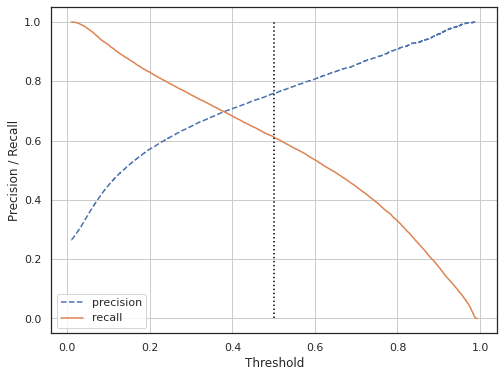

In [154]:
precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba)
print(precisions.shape, recalls.shape, thresholds.shape)

plt.figure(figsize=(8,6))
threshold_boundary = thresholds.shape[0]
plt.plot(thresholds, precisions[0:threshold_boundary], "--", label='precision')
plt.plot(thresholds, recalls[0:threshold_boundary], "-", label='recall')
plt.plot([0.5,0.5], [0.0,1.0], ':', color='black')
plt.xlabel('Threshold')
plt.ylabel('Precision / Recall')
plt.legend()
plt.grid()
plt.show()

In [144]:
auc = roc_auc_score(y_test, pred_proba)
print("AUC: {0:.8f}".format(auc))

AUC: 0.88634196


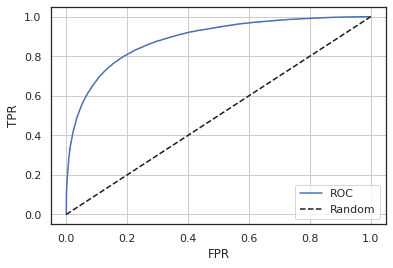

In [161]:
fprs, tprs, thresholds = roc_curve(y_test, pred_proba)

plt.plot(fprs, tprs, label="ROC")
plt.plot([0,1],[0,1], 'k--', label="Random")
plt.legend(loc=4)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.grid()
plt.show()

In [95]:
ftr_imp = pd.DataFrame(lgbm_clf.feature_importances_, index=features, columns=["Feature_Importances"])
ftr_imp.sort_values("Feature_Importances", ascending=False)

,Feature_Importances
cont4,228
cont2,172
cont6,169
cont5,166
cat10,162
cont1,153
cat8,151
cat1,148
cat7,139
cont3,132


<AxesSubplot:xlabel='Feature_Importances'>

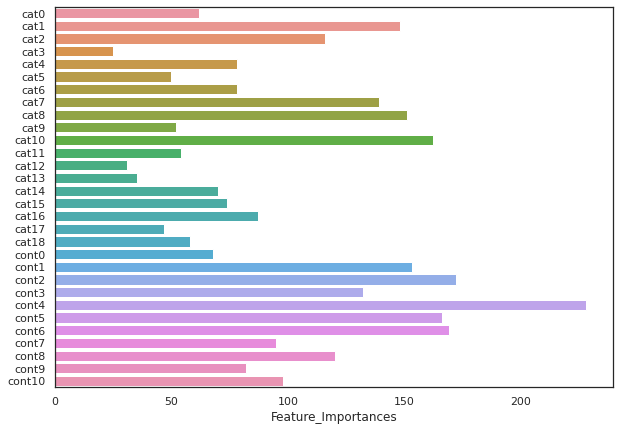

In [143]:
plt.figure(figsize=(10,7))
sns.barplot("Feature_Importances", features, data=ftr_imp)